In [109]:
import random
import re
import pandas as pn
import numpy as np
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/Users/luyuxuan/opt/anaconda3/envs/MedIP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/luyuxuan/Desktop/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

In [56]:
# load data
tweet = pd.read_csv('/Users/luyuxuan/Desktop/Data_csv/train.csv')
test = pd.read_csv('/Users/luyuxuan/Desktop/Data_csv/test.csv')
submission = pd.read_csv('/Users/luyuxuan/Desktop/Data_csv/sample.csv')
tweet.shape, test.shape, submission.shape

((7613, 5), (3263, 4), (3263, 2))

In [57]:
# check data
def show_info(data, is_matrix_transpose=False):
    print('\n' * 2)
    # basic shape
    print('data shape is: {}   sample number {}   attribute number {}\n'.format(data.shape, data.shape[0], data.shape[1]))
    # attribute(key)
    print('data columns number {}  \nall columns: {}\n'.format(len(data.columns) ,data.columns))
    # value's null
#     print('data all attribute count null:\n', data.isna().sum())
    # data value analysis and data demo
#     if is_matrix_transpose:
#         print('data value analysis: ', data.describe().T)
#         print('data demo without matrix transpose: ', data.head().T)
#     else:
#         print('data value analysis: ', data.describe())
#         print('data demo without matrix transpose: ', data.head())
show_info(tweet)
show_info(test)
show_info(submission)





data shape is: (7613, 5)   sample number 7613   attribute number 5

data columns number 5  
all columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')




data shape is: (3263, 4)   sample number 3263   attribute number 4

data columns number 4  
all columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')




data shape is: (3263, 2)   sample number 3263   attribute number 2

data columns number 2  
all columns: Index(['id', 'target'], dtype='object')



<AxesSubplot: >

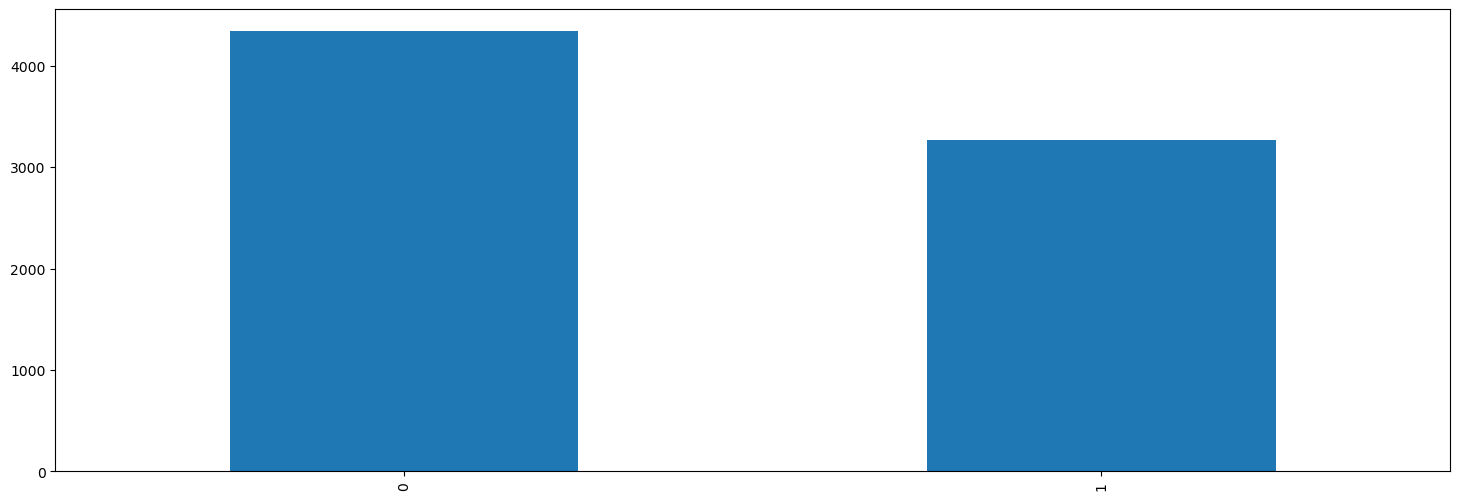

In [58]:
# plot -> label -> classification
tweet.target.value_counts().plot.bar()

In [59]:
# 增添长度属性到 true and not ==> 利用apply 来应用
def length(text):
    return len(text)
# new attribute 'length' in train 
tweet['length'] = tweet['text'].apply(length)
show_info(tweet)




data shape is: (7613, 6)   sample number 7613   attribute number 6

data columns number 6  
all columns: Index(['id', 'keyword', 'location', 'text', 'target', 'length'], dtype='object')



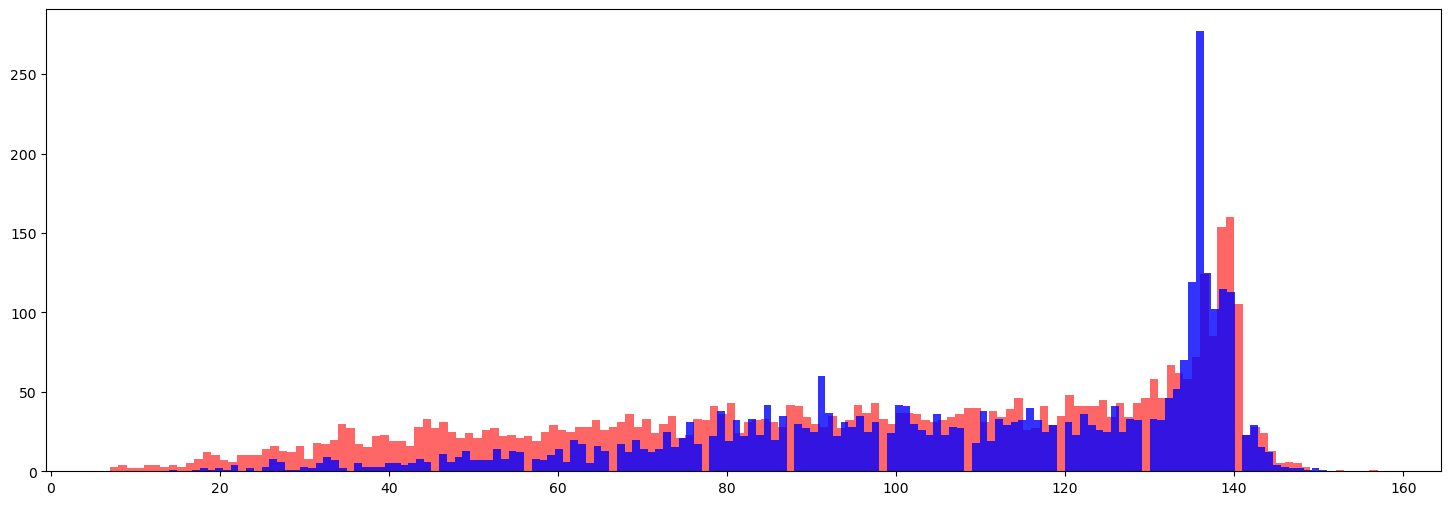

In [60]:
# plot -> value -> length
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha=0.6, bins=bins, label='Not', color='red')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha=0.8, bins=bins, label='Real', color='blue')
plt.show()

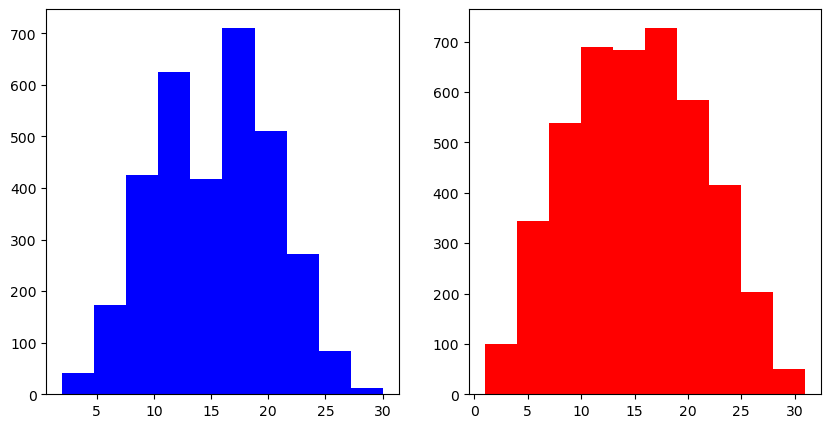

In [61]:
# number of words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = tweet[tweet['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='blue')
tweet_len = tweet[tweet['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='red')
plt.show()


/var/folders/f8/x31_l_fn48935k_d48kct7q40000gn/T/ipykernel_24656/2637755261.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
/var/folders/f8/x31_l_fn48935k_d48kct7q40000gn/T/ipykernel_24656/2637755261.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

<AxesSubplot: xlabel='text', ylabel='Density'>

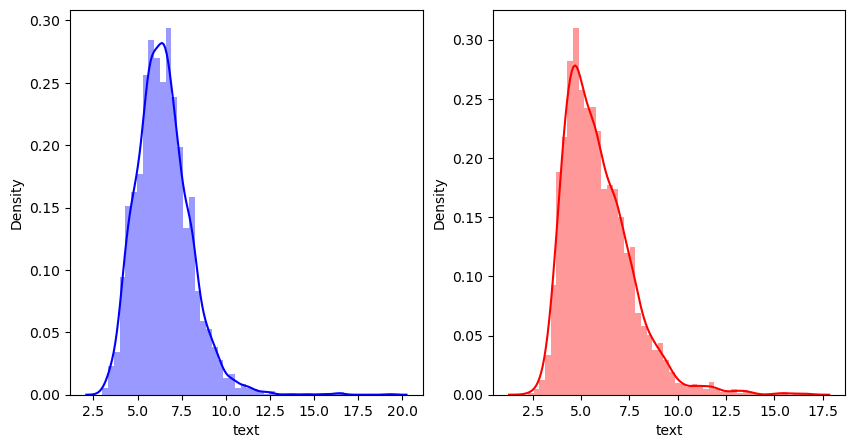

In [62]:
# average length in a text
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
word = tweet[tweet['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='blue')
word = tweet[tweet['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='red')

## Data preprocessing
init corpus (split by 0 and 1)
common stopwords in tweets (use ntlk's corpus to get stopwords)
punctuation in tweets (use string to get punctuation)
common word in tweets (use Counter in collections)
N-gram analysis => get relationship between different gram

In [63]:
!pip3 install nltk


In [64]:
!pip3 install sklearn

In [65]:
from nltk.corpus import stopwords
# set english
stop = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
# create corpus to get only corpus
def create_corpus(target):
    corpus = []
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet, target):
    corpus = []
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

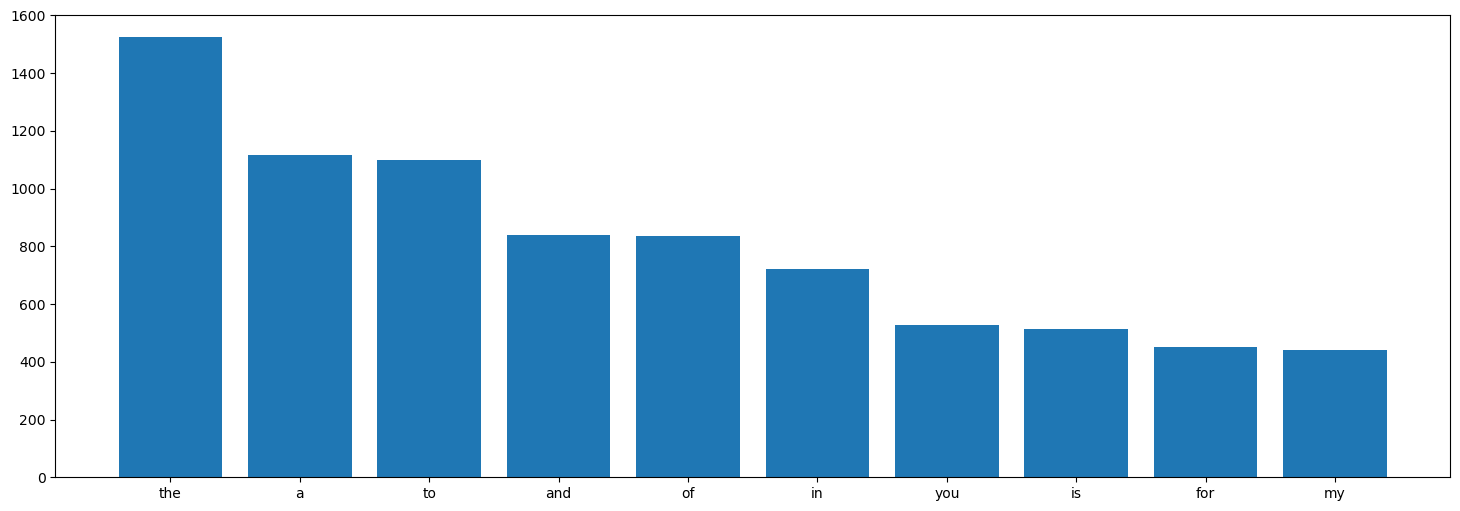

In [67]:
# create corpus 0 => not
corpus = create_corpus(0)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

# then plot stop words 
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y = zip(*top)
plt.bar(x, y)

<BarContainer object of 10 artists>

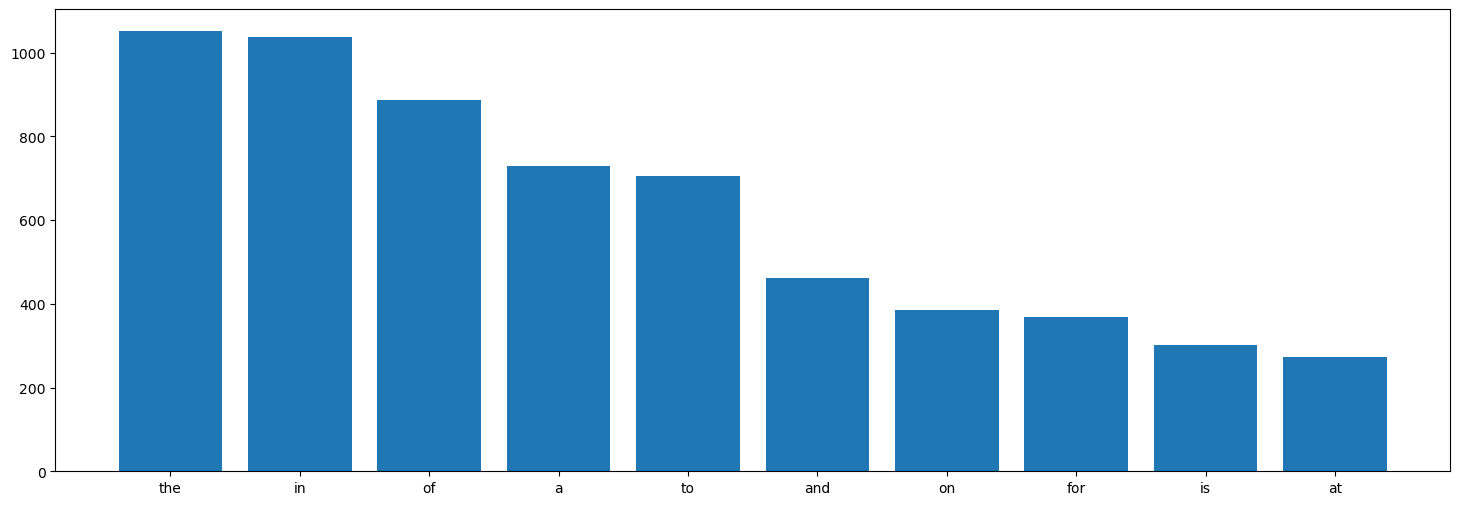

In [68]:
# create corpus 1 => real
corpus = create_corpus(1)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x, y = zip(*top)
plt.bar(x, y)


<BarContainer object of 20 artists>

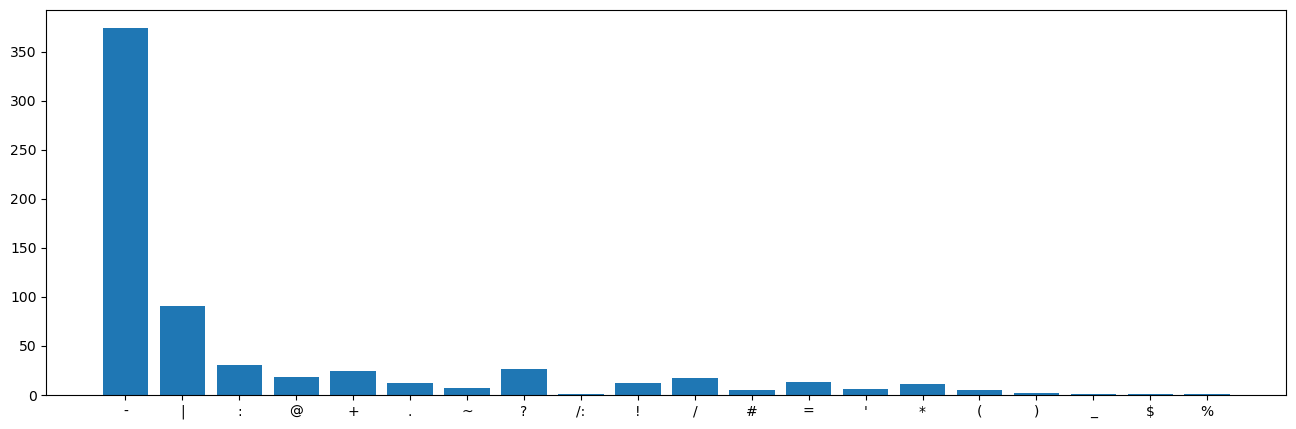

In [69]:
# punctuation 0 => not
plt.figure(figsize=(16, 5))
corpus = create_corpus(0)
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1
x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 18 artists>

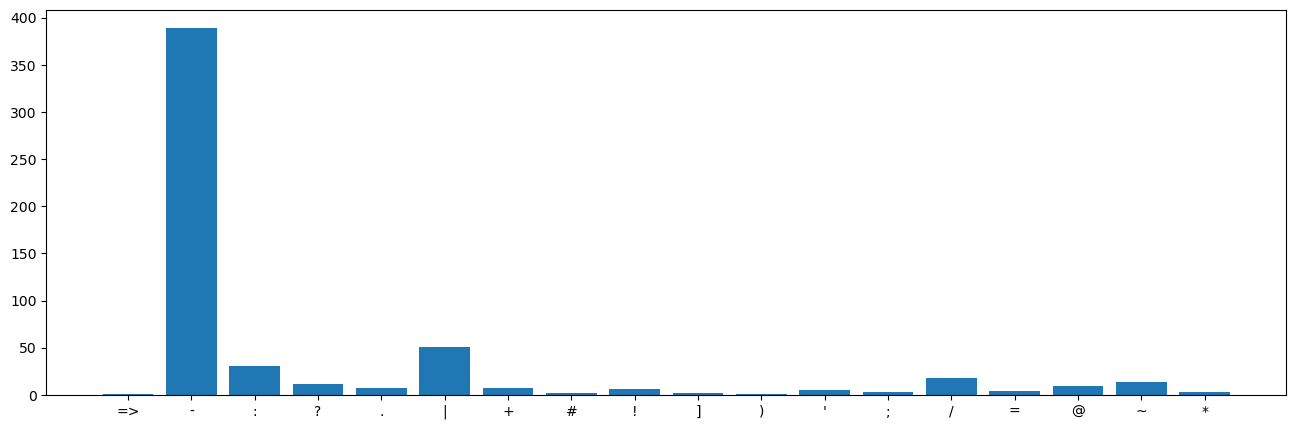

In [70]:
# punctuation 1 => Real
plt.figure(figsize=(16, 5))
corpus = create_corpus(1)
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i] += 1

x, y = zip(*dic.items())
plt.bar(x, y)

<AxesSubplot: >

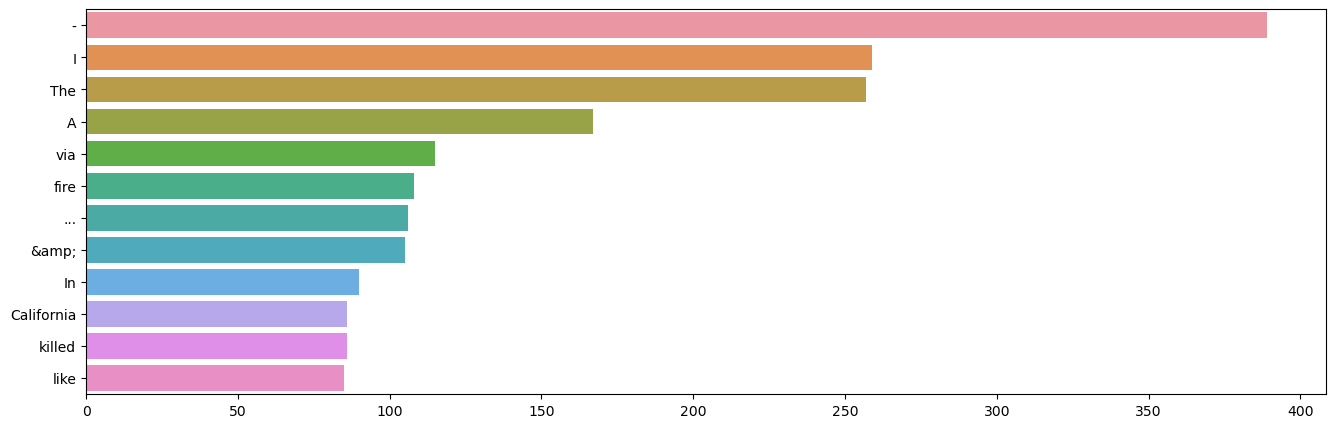

In [71]:
# common words
plt.figure(figsize=(16, 5))
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)

<AxesSubplot: >

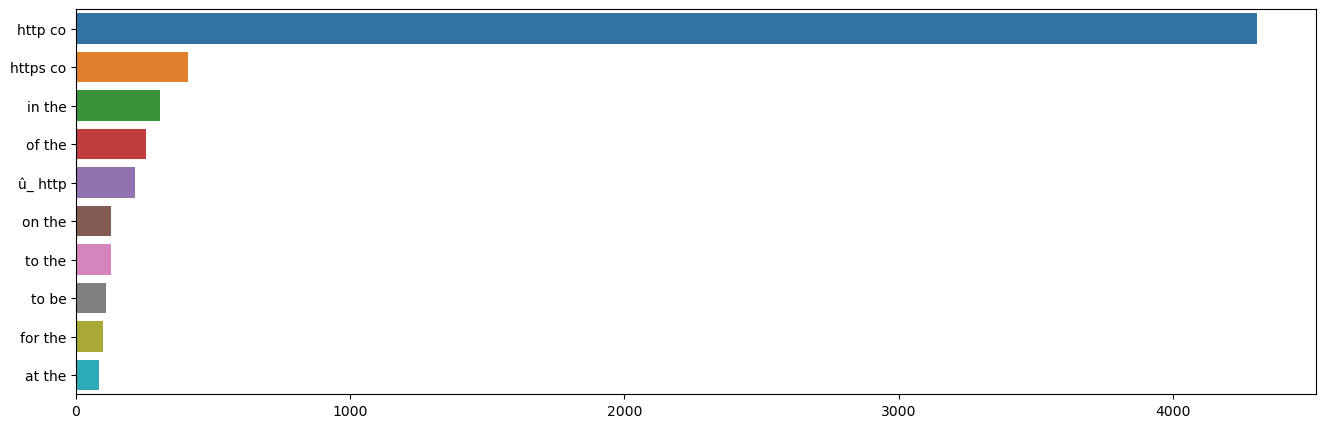

In [72]:
# N-gram analysis 多变量分析
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)

# Data cleaning
concat
remove
url
html tag
emojis
punctuations


In [73]:
import re

In [74]:
# concat
df = pd.concat([tweet, test])
df.shape

(10876, 6)

In [75]:
# method
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# use apply to remove
df['text'] = df['text'].apply(lambda x: remove_URL(x))
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text'] = df['text'].apply(lambda x: remove_punct(x))

## Model
prework
model prework
train test split
embedding [use some ways to extract features]
build
visualize
use tf-idf ==> get word vec
use GloVe to embedding => 全局的，固定词典
base model based on GloVe
train test split

In [1]:
from sklearn.model_selection import train_test_split



In [2]:
# embedding => use following some ways to extract features
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib



In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



In [4]:
pip install --upgrade charset-normalizer


Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip uninstall keras -y
!pip uninstall requests -y
!pip uninstall charset-normalizer -y
!pip install keras
!pip install requests
!pip install charset-normalizer


Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: requests 2.31.0
Uninstalling requests-2.31.0:
  Successfully uninstalled requests-2.31.0
Found existing installation: charset-normalizer 3.1.0
Uninstalling charset-normalizer-3.1.0:
  Successfully uninstalled charset-normalizer-3.1.0
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached charset_normalizer-3.1.0-cp311-cp311-macosx_11_0_arm64.whl (121 kB)


In [6]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install chardet


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade charset_normalizer


Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install charset_normalizer


In [10]:
conda install tensorflow


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [11]:
conda install keras


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [78]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=2)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [79]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Not')
        blue_patch = mpatches.Patch(color='blue', label='Real')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
# plot_LSA(X_train_counts, y_train)
plt.show()

<Figure size 1600x1600 with 0 Axes>

In [80]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))
# plot_LSA(X_train_tfidf, y_train)
plt.show()


<Figure size 1600x1600 with 0 Axes>

In [81]:
def create_corpus_new(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus
corpus = create_corpus_new(df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10876/10876 [00:00<00:00, 14339.14it/s]


In [82]:
embedding_dict = {}
# get glove 100b txt 
with open('/Users/luyuxuan/Desktop/kaggle/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [83]:
import sys
sys.modules['charset_normalizer'] = None
import keras.preprocessing.text as kt


In [84]:
from keras.preprocessing.text import Tokenizer

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [86]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

word_index = tokenizer_obj.word_index
print('Number of unique words: ', len(word_index))

Number of unique words:  22807


In [87]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 22807/22807 [00:00<00:00, 736068.72it/s]


In [88]:
# model dependencies
from keras.models import Model, Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.optimizers import Adam
from keras.initializers import Constant

# train test split
from sklearn.model_selection import train_test_split


In [89]:
model = Sequential()

model.add(Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=3e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2280800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [106]:
# extract valid content
train = tweet_pad[:tweet.shape[0]]
test = tweet_pad[:tweet.shape[0]:]
# then train test split
X_train, X_test, y_train, y_test = train_test_split(train, tweet['target'].values, test_size=0.25)
X_train.shape, X_test.shape

((5709, 50), (1904, 50))

In [107]:
# test plot
# fig = plot_LSA(train, tweet['target'])
plt.show()

In [108]:
# fit
history = model.fit(X_train, y_train, batch_size=100, epochs=50, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
58/58 - 3s - loss: 0.2787 - accuracy: 0.8851 - val_loss: 0.1802 - val_accuracy: 0.9280 - 3s/epoch - 48ms/step
Epoch 2/50
58/58 - 3s - loss: 0.2614 - accuracy: 0.8939 - val_loss: 0.1819 - val_accuracy: 0.9280 - 3s/epoch - 47ms/step
Epoch 3/50
58/58 - 3s - loss: 0.2632 - accuracy: 0.8925 - val_loss: 0.1866 - val_accuracy: 0.9265 - 3s/epoch - 50ms/step
Epoch 4/50
58/58 - 3s - loss: 0.2532 - accuracy: 0.8951 - val_loss: 0.2008 - val_accuracy: 0.9160 - 3s/epoch - 49ms/step
Epoch 5/50
58/58 - 3s - loss: 0.2515 - accuracy: 0.8988 - val_loss: 0.1847 - val_accuracy: 0.9291 - 3s/epoch - 50ms/step
Epoch 6/50
58/58 - 3s - loss: 0.2606 - accuracy: 0.8917 - val_loss: 0.1929 - val_accuracy: 0.9254 - 3s/epoch - 48ms/step
Epoch 7/50
58/58 - 3s - loss: 0.2574 - accuracy: 0.8949 - val_loss: 0.1860 - val_accuracy: 0.9265 - 3s/epoch - 47ms/step
Epoch 8/50
58/58 - 3s - loss: 0.2545 - accuracy: 0.9000 - val_loss: 0.1843 - val_accuracy: 0.9280 - 3s/epoch - 48ms/step
Epoch 9/50
58/58 - 3s - loss: 0.

In [66]:
# predict
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')
test_pred_GloVe = model.predict(test)
test_pred_GloVe_int = test_pred_GloVe.round().astype('int')

238/238 [==============================] - 3s 13ms/step
